# Income Classification

Original Dataset: https://archive.ics.uci.edu/ml/datasets/adult

# TODO
Welche Kategorien haben aussagekräftige Verteilungen?
Boxplots nach Zielgröße und Kategorien

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from matplotlib.patches import Patch
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap

import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score




## Preparation

### Load data

In [2]:
train_df = pd.read_csv('adult.data', delimiter=',', skipinitialspace=True, na_values=['?'])
test_df = pd.read_csv('adult.test', delimiter=',', skipinitialspace=True, na_values=['?'])

train_df_size = train_df.shape[0]
test_df_size = test_df.shape[0]
df_size = train_df_size + test_df_size

print(f'Train Dataset Size: {train_df_size} ({(train_df_size/df_size):.2%})')
print(f'Test Dataset Size: {test_df_size} ({(test_df_size/df_size):.2%})')

Train Dataset Size: 32561 (66.67%)
Test Dataset Size: 16281 (33.33%)


### Pre Processing

First we need to label the data with ones for income >50k and zeros for income <=50k.

In [3]:
train_df['income'] = train_df['income'].apply(lambda x: 1 if x == '>50K' else 0)
test_df['income'] = test_df['income'].apply(lambda x: 1 if x == '>50K.' else 0)

**education** is encoded in **education-num** with numbe from 1 to 16. We can also drop this variable, because the information is useless.

In [4]:
train_df = train_df.drop('education-num',axis= 1)
test_df = test_df.drop("education-num", axis = 1)

### Dataset Info

The dataset contains 9 character variables and 6 numerical variables.
**income** is the target variable.

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   marital-status  32561 non-null  object
 5   occupation      30718 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  31978 non-null  object
 13  income          32561 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


### Dataset statistics

### Check missing values and fill it with most recent values

In [6]:
train_df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [7]:
train_df['workclass'].fillna(train_df['workclass'].mode()[0], inplace=True)
train_df['occupation'].fillna(train_df['occupation'].mode()[0], inplace=True)
train_df['native-country'].fillna(train_df['native-country'].mode()[0], inplace=True)   

test_df['workclass'].fillna(train_df['workclass'].mode()[0], inplace=True)
test_df['occupation'].fillna(train_df['occupation'].mode()[0], inplace=True)
test_df['native-country'].fillna(train_df['native-country'].mode()[0], inplace=True)   

In [8]:
train_df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

## Numeric

In [9]:
train_df.describe().T

count           mean            std      min       25%   
age             32561.0      38.581647      13.640433     17.0      28.0  \
fnlwgt          32561.0  189778.366512  105549.977697  12285.0  117827.0   
capital-gain    32561.0    1077.648844    7385.292085      0.0       0.0   
capital-loss    32561.0      87.303830     402.960219      0.0       0.0   
hours-per-week  32561.0      40.437456      12.347429      1.0      40.0   
income          32561.0       0.240810       0.427581      0.0       0.0   

                     50%       75%        max  
age                 37.0      48.0       90.0  
fnlwgt          178356.0  237051.0  1484705.0  
capital-gain         0.0       0.0    99999.0  
capital-loss         0.0       0.0     4356.0  
hours-per-week      40.0      45.0       99.0  
income               0.0       0.0        1.0

## Variables

In [10]:
categorical = [var for var in train_df.columns if train_df[var].dtype==object]
numeric = [var for var in train_df.columns if train_df[var].dtype!=object]
numeric.remove("income")

print('There are {} categorical variables:\n'.format(len(categorical)))

for var in categorical:

    print(f'{var} contains {len(train_df[var].unique())} labels')

print('\nThere are {} numeric variables:\n\n{}'.format(len(numeric), numeric))

There are 8 categorical variables:

workclass contains 8 labels
education contains 16 labels
marital-status contains 7 labels
occupation contains 14 labels
relationship contains 6 labels
race contains 5 labels
sex contains 2 labels
native-country contains 41 labels

There are 5 numeric variables:

['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']


# Charts

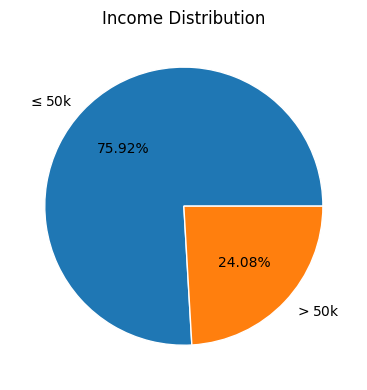

In [11]:
plt.figure(figsize=(4,4))
train_df['income'].value_counts().plot.pie(labels=[r'$\leq50$k', r'$>50$k'], autopct='%1.2f%%', wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.title('Income Distribution')
plt.tight_layout()
plt.ylabel('')
plt.show()

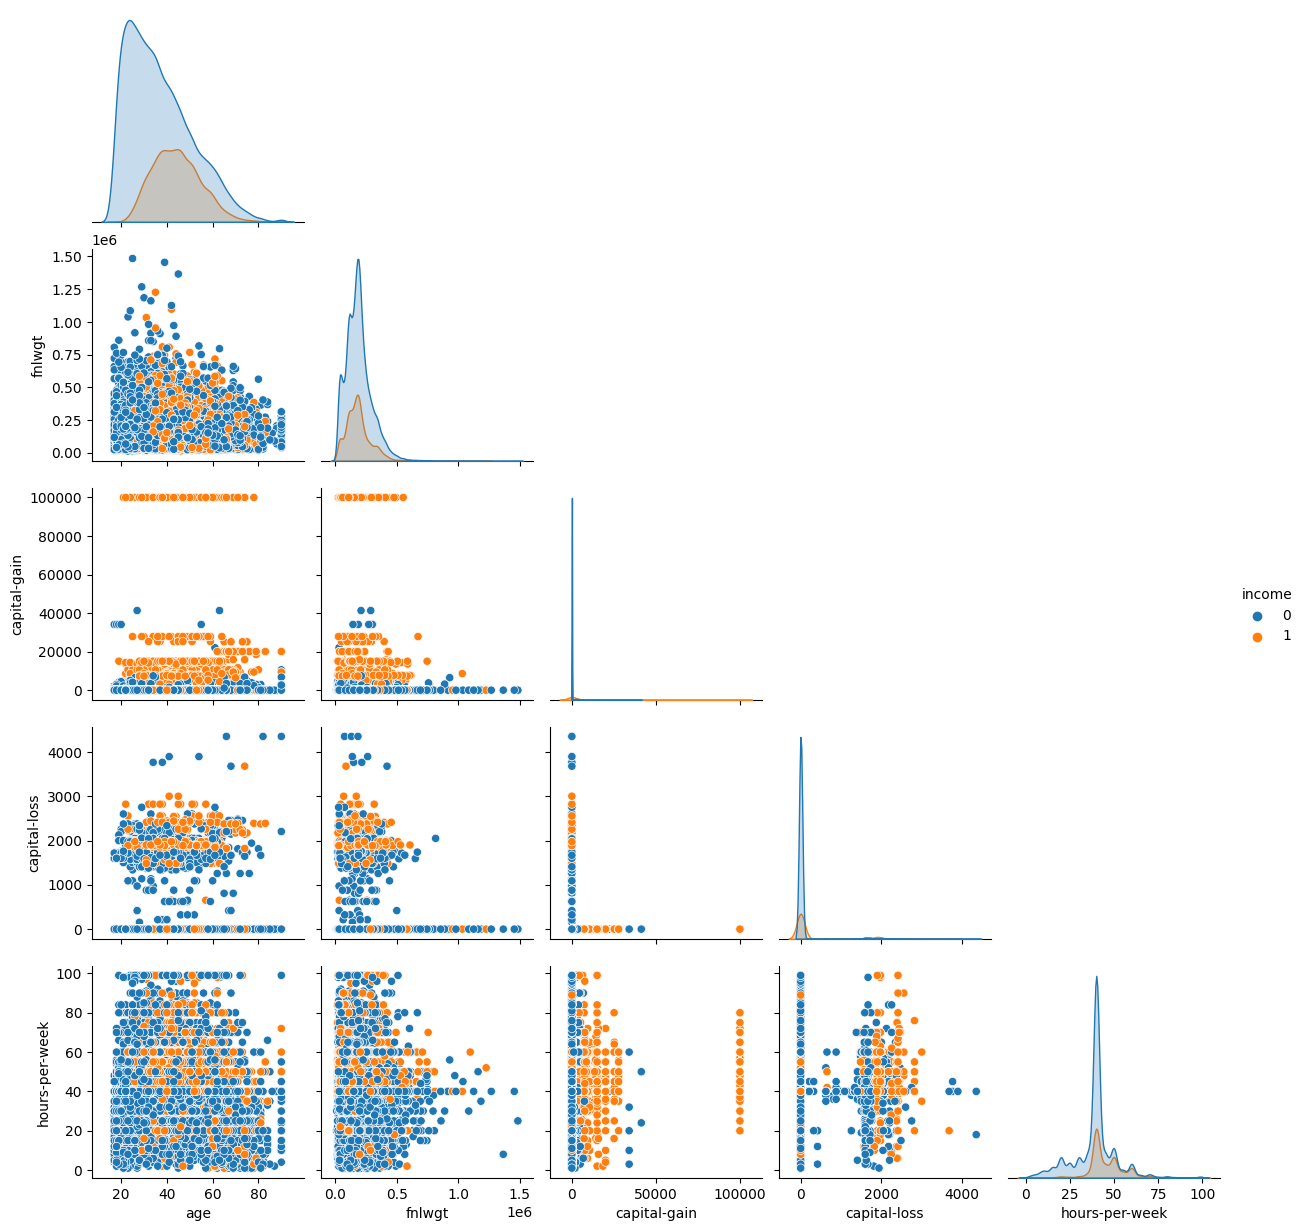

In [34]:
sns.pairplot(train_df.drop(categorical,axis=1), hue='income', corner=True)
plt.show()

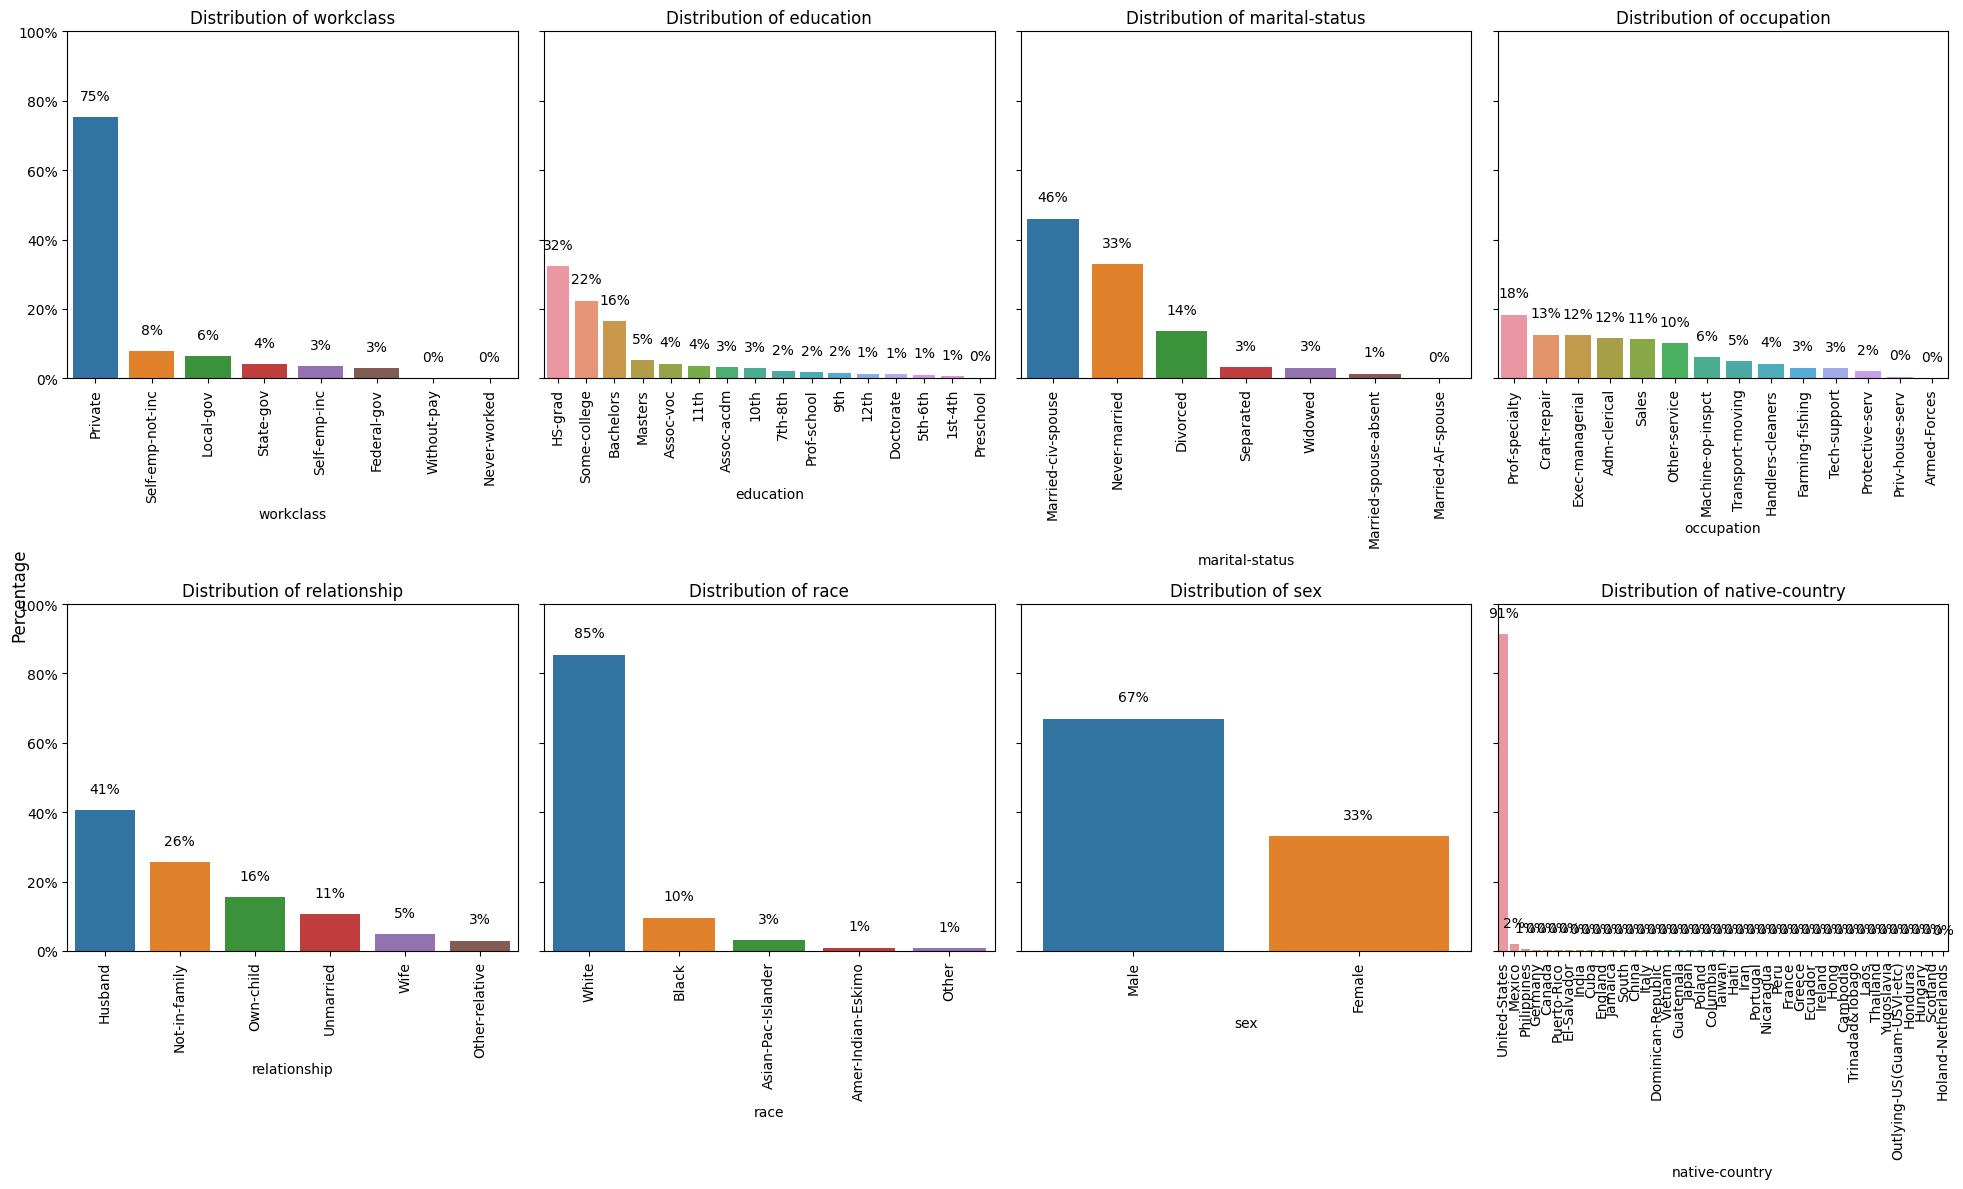

In [12]:
rows=2
cols=4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    pct_counts = train_df[variable].value_counts(normalize=True)
    sns.barplot(x=pct_counts.index, y=pct_counts.values, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_title('Distribution of {}'.format(variable))

    for j, p in enumerate(ax.patches):
        ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.05, '{:.0%}'.format(pct_counts.values[j]), ha='center')

plt.tight_layout()
plt.show()

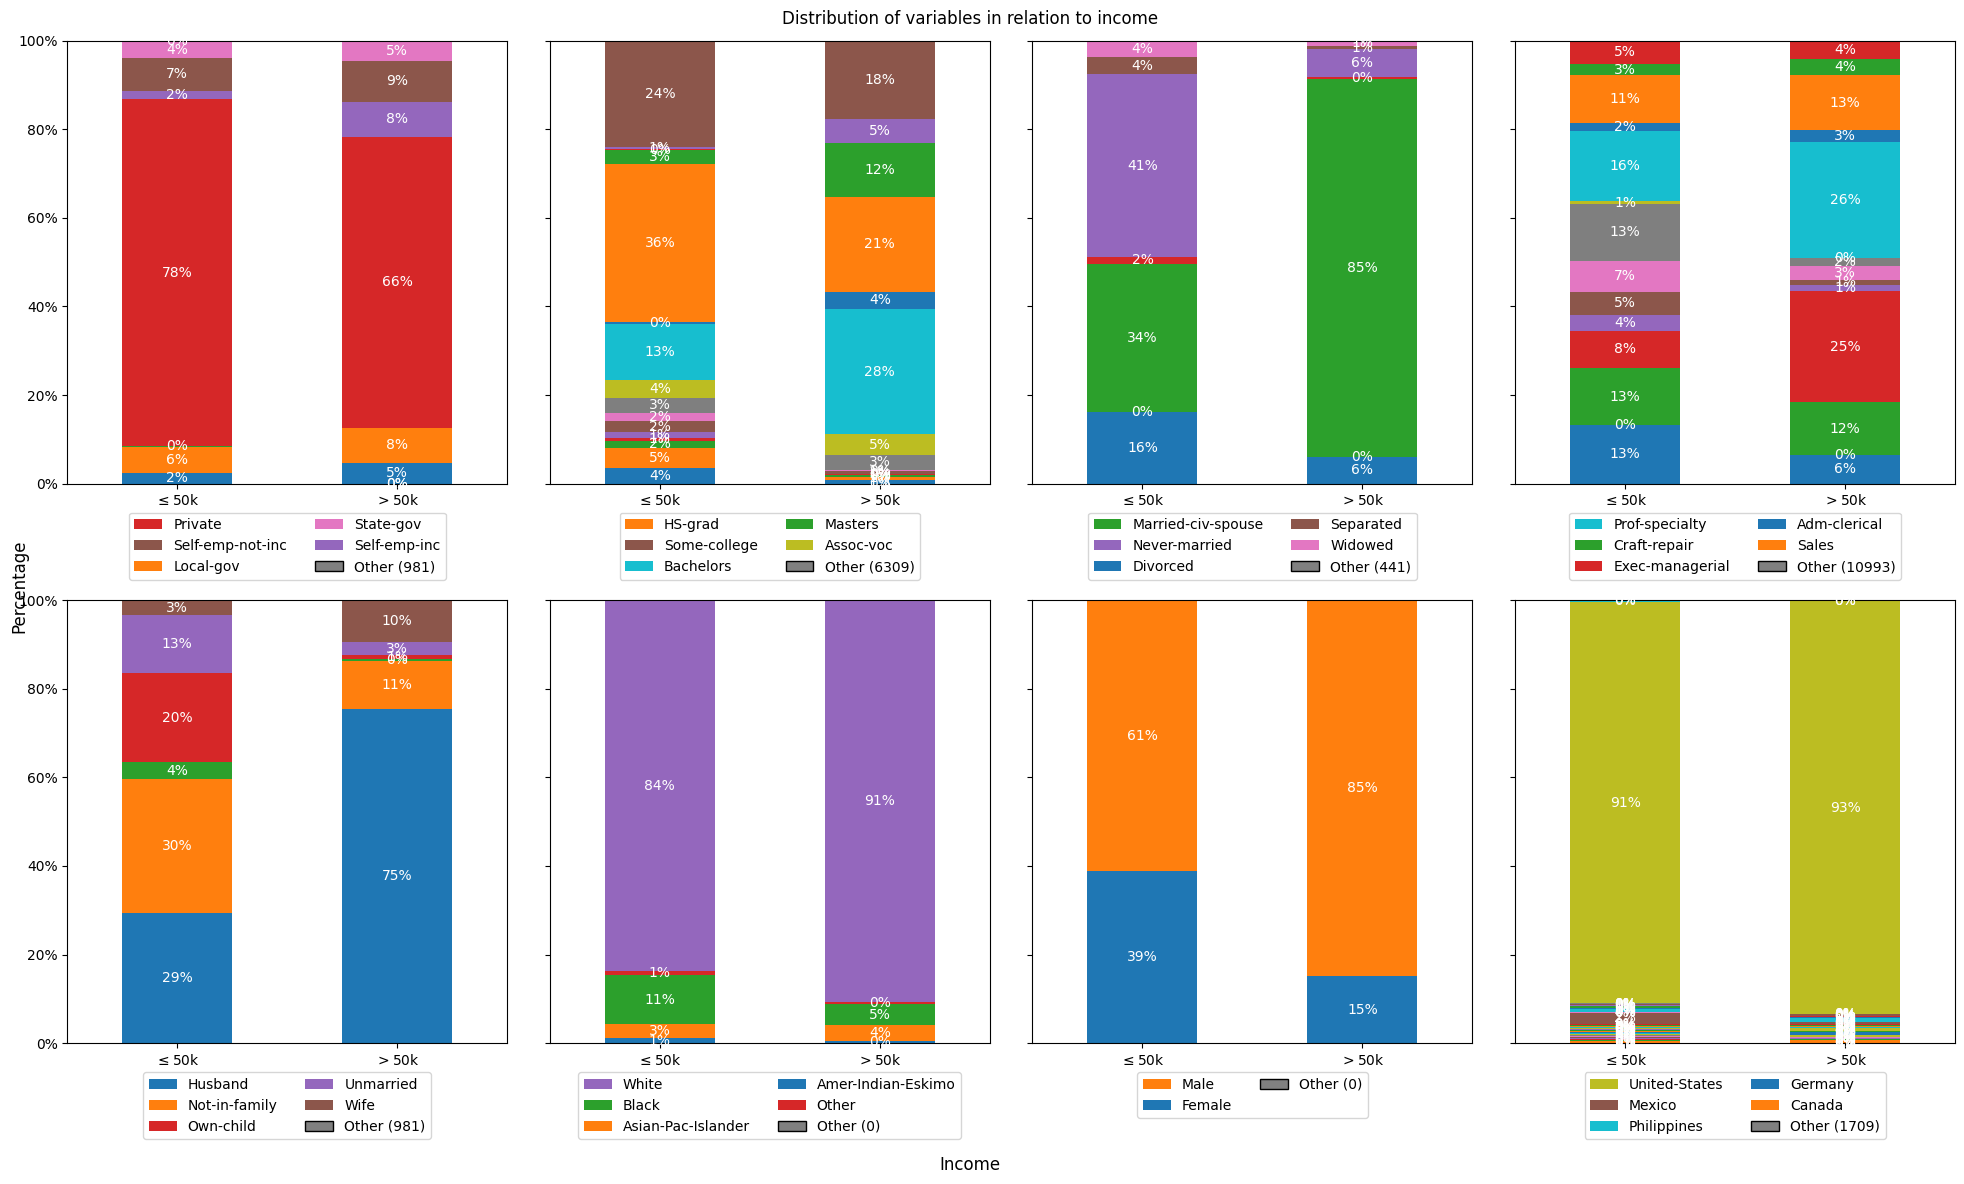

In [13]:
rows=2
cols=4

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 6*rows), sharey=True)
fig.suptitle('Distribution of variables in relation to income')
fig.supxlabel('Income')
fig.supylabel('Percentage')

for i, variable in enumerate(categorical):
    row = i // cols
    col = i % cols
    ax = axes[row][col]
    
    ct = pd.crosstab(train_df['income'], train_df[variable])
    ct_pct = ct.apply(lambda r: r/r.sum(), axis=1)

    ct_pct.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_xticklabels([r'$\leq50$k', r'$>50$k'], rotation=0)
    yticks = mtick.PercentFormatter(1)
    ax.yaxis.set_major_formatter(yticks)
    ax.set_ylim([0, 1])
    ax.set_xlabel('')

    handles, labels = ax.get_legend_handles_labels()
    sorted_labels = sorted(labels, key=lambda x: -ct[x].sum())
    top_labels = sorted_labels[:5]
    remaining_labels = sorted_labels[5:]
    top_handles = [handles[labels.index(l)] for l in top_labels]
    remaining_sum = sum([ct[x].sum() for x in remaining_labels])
    top_labels.append(f'Other ({remaining_sum})')
    top_handles.append(Patch(facecolor='gray', edgecolor='black'))
    ax.legend(top_handles, top_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)


    for i in ax.containers:
        ax.bar_label(i, label_type='center', color="white", fontsize=10, fmt='{:.0%}')

plt.tight_layout()
plt.show()

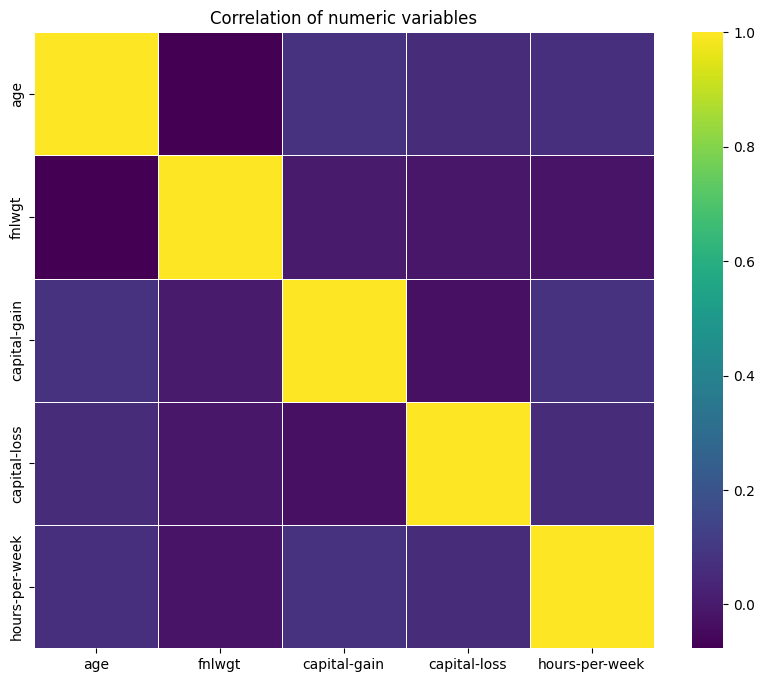

In [15]:
plt.figure(figsize=(10,8),dpi=100)
sns.heatmap(train_df[numeric].corr(),cmap="viridis",linewidth=0.5)
plt.title("Correlation of numeric variables")
plt.show()

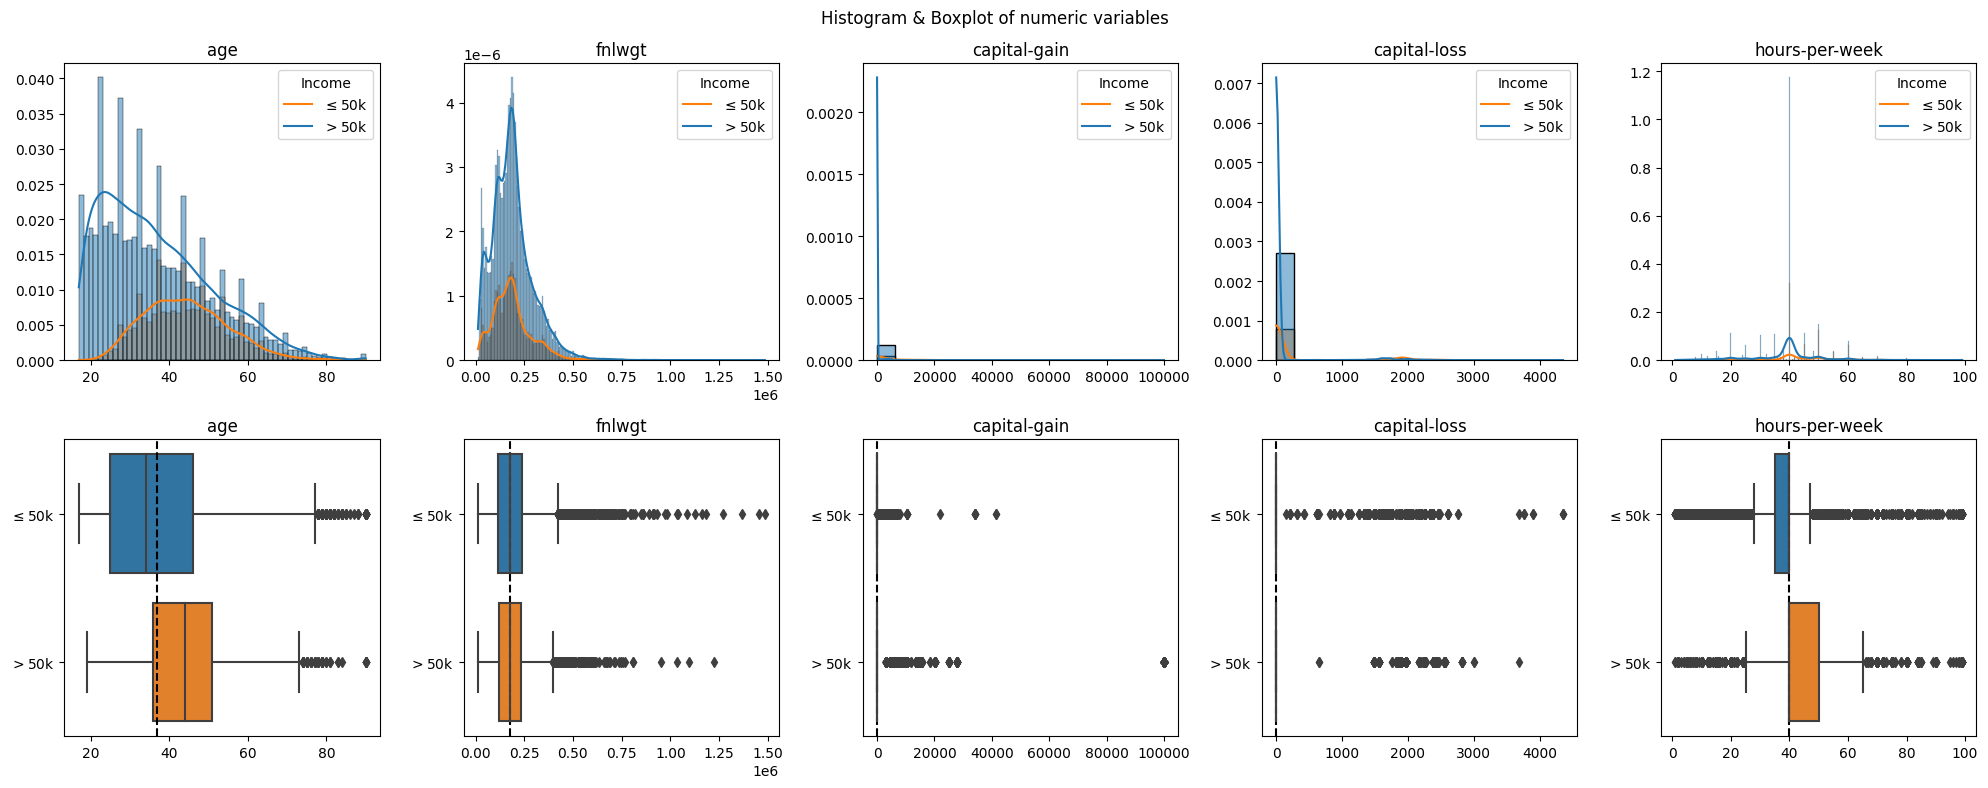

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=len(numeric), figsize=(20, 8))
fig.suptitle("Histogram & Boxplot of numeric variables")

for i, variable in enumerate(numeric):
    sns.histplot(data=train_df, x=variable, hue='income', ax=axes[0][i], kde=True, stat='density')
    sns.boxplot(data=train_df, x=variable, y='income', ax=axes[1][i], orient='h')

    axes[0][i].set_xlabel(None)
    axes[0][i].set_ylabel(None)
    axes[0][i].set_title(variable)
    axes[0][i].legend(title='Income', labels=['$\leq50$k', '$>50$k'])

    axes[1][i].set_xlabel(None)
    axes[1][i].set_ylabel(None)
    axes[1][i].set_title(variable)
    axes[1][i].set_yticklabels(['$\leq50$k', '$>50$k'])

    median = train_df[variable].median()
    axes[1][i].axvline(median, linestyle='--', color='black')
    
plt.tight_layout()
plt.show()

In [18]:
train_df.drop(categorical, axis=1)

age  fnlwgt  capital-gain  capital-loss  hours-per-week  income
0       39   77516          2174             0              40       0
1       50   83311             0             0              13       0
2       38  215646             0             0              40       0
3       53  234721             0             0              40       0
4       28  338409             0             0              40       0
...    ...     ...           ...           ...             ...     ...
32556   27  257302             0             0              38       0
32557   40  154374             0             0              40       1
32558   58  151910             0             0              40       0
32559   22  201490             0             0              20       0
32560   52  287927         15024             0              40       1

[32561 rows x 6 columns]

## Results

- We can delete the variable **native-country**. 
- We can encode **sex** to a binary variable
- encode all categorical variables
- age and fnlwgt looks like they can be logarithmically transformed

In [18]:
train_df = train_df.drop('native-country',axis= 1)
test_df = test_df.drop("native-country", axis = 1)
categorical.remove('native-country')

In [19]:
print(f'Train Shape before encoding: {train_df.shape}')
print(f'Test Shape before encoding: {test_df.shape}')

onehot_encoder = ce.OneHotEncoder(cols=categorical)
train_df = onehot_encoder.fit_transform(train_df)
test_df = onehot_encoder.transform(test_df)

print(f'Train Shape after encoding: {train_df.shape}')
print(f'Test Shape after encoding: {test_df.shape}')

train_df.head()

Train Shape before encoding: (32561, 13)
Test Shape before encoding: (16281, 13)
Train Shape after encoding: (32561, 64)
Test Shape after encoding: (16281, 64)


age  workclass_1  workclass_2  workclass_3  workclass_4  workclass_5   
0   39            1            0            0            0            0  \
1   50            0            1            0            0            0   
2   38            0            0            1            0            0   
3   53            0            0            1            0            0   
4   28            0            0            1            0            0   

   workclass_6  workclass_7  workclass_8  fnlwgt  ...  race_2  race_3  race_4   
0            0            0            0   77516  ...       0       0       0  \
1            0            0            0   83311  ...       0       0       0   
2            0            0            0  215646  ...       0       0       0   
3            0            0            0  234721  ...       1       0       0   
4            0            0            0  338409  ...       1       0       0   

   race_5  sex_1  sex_2  capital-gain  capital-loss  hours-per-week  income  
0       0      1      0          2174             0              40       0  
1       0      1      0             0             0              13       0  
2       0      1      0             0             0              40       0  
3       0      1      0             0             0              40       0  
4       0      0      1             0             0              40       0  

[5 rows x 64 columns]

# Principal component analysis (PCA)

### Notizen
Wieso Dimensions Reduktion?
1. Menschen können sich sehr schwer vorstellen wie höhere Dimensionen aussehen / auch schwer zu Visualisieren
2. Man benötigt sehr viel computing power um ML Algorithmen mit vielen Dimensionen zu trainieren
3. ML-Modelle basierend auf sehr vielen Dimensionen werden ungenau

https://setosa.io/ev/principal-component-analysis/
Was ist und macht PCA?

- PCA führt zu einem guten Verständnis der Daten
- Zur Entscheidung wie viele Hauptkomponenten gewählt werden kmodel man sich der erklärten Varianz zu nutze machen. (Proportion of variance explained PVE)
- Sie kmodel auch als Hilfsmittel für das überwachte Lernen vorgeschalten werden
- Vor der PCA sollte man alle Variable skalieren damit Sie alle die Varianz 1 besitzen und somit besser zueinander in Relation stehen

Wie ist das vorgehen bei der PCA?
1. Standardisieren / Skalieren
2. Kovarianzmatrix berechnen
3. Eigenwerte und Eigenvektoren berechnen
4. Egenwerte und -vektoren sortieren (diejenigen mit den höchsten Werten haben die höchste Signifikanz)
5. Transform the original matrix of data by multiplying it top n eigenvectors selected above.

Oder Sklearn PCA



In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

pca_train_df = train_df.drop(['income'], axis=1)
pca_test_df = test_df.drop(['income'], axis=1)
#Nur auf trainingsdaten fitten
pca_train_df_scale = scaler.fit_transform(pca_train_df)
pca_test_df_scale = scaler.fit_transform(pca_test_df)



In [21]:
pca2 = PCA(n_components = 2)
principalComponents = pca2.fit_transform(pca_train_df_scale)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, train_df[['income']]], axis=1)
finalDf.head()

principal component 1  principal component 2  income
0              -0.729532               0.671484       0
1               2.764603               1.071136       0
2              -0.646382              -0.790337       0
3               1.058179              -1.406682       0
4              -1.325024               1.969448       0

In [22]:
print('\nDescription')
print(finalDf.describe())
print('\nInfo')
print(finalDf.info())



Description
       principal component 1  principal component 2        income
count           3.256100e+04           3.256100e+04  32561.000000
mean            2.016343e-16          -7.070294e-17      0.240810
std             2.118745e+00           1.602882e+00      0.427581
min            -4.413942e+00          -4.326590e+00      0.000000
25%            -1.861329e+00          -1.111491e+00      0.000000
50%            -4.284757e-01          -9.395478e-02      0.000000
75%             2.126846e+00           1.099713e+00      0.000000
max             4.782692e+00           5.730512e+00      1.000000

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   principal component 1  32561 non-null  float64
 1   principal component 2  32561 non-null  float64
 2   income                 32561 non-null  int64  
dtypes: float64(2),

Text(0, 0.5, 'pc2')

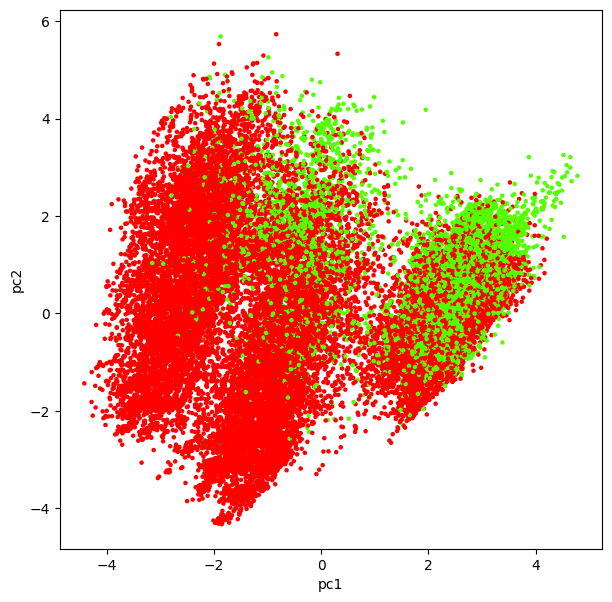

In [23]:
plt.figure(figsize=(7,7))
plt.scatter(finalDf['principal component 1'],finalDf['principal component 2'],c=finalDf['income'],cmap='prism', s =5)
plt.xlabel('pc1')
plt.ylabel('pc2')

In [24]:
#n von pca ist immer die anzahl an variablen
pca = PCA(n_components = 63)

principalComponents = pca.fit_transform(pca_train_df_scale)   

# principalComponents = pca.fit(pca_train_df_scale)



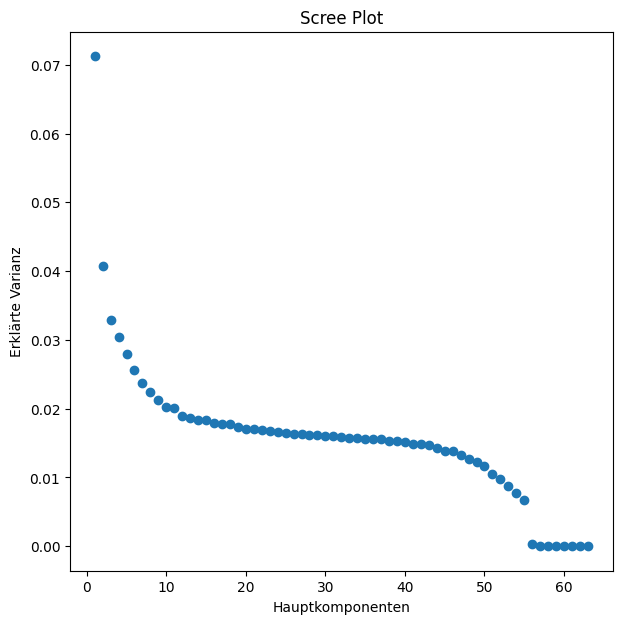

In [25]:
plt.figure(figsize=(7,7))
PC_values = np.arange(pca.n_components_) + 1
plt.scatter(PC_values, pca.explained_variance_ratio_)

plt.title('Scree Plot')
plt.xlabel('Hauptkomponenten')
plt.ylabel('Erklärte Varianz')
plt.show()


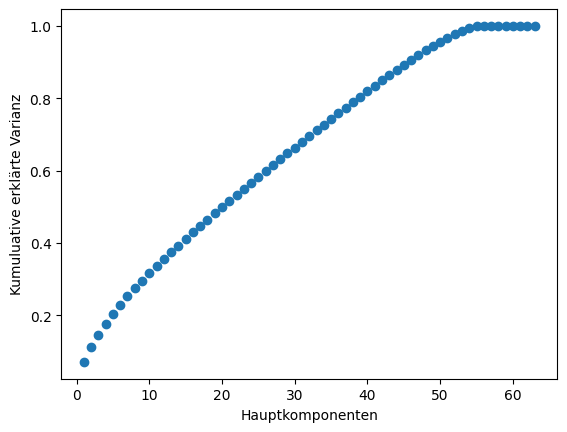

In [26]:
plt.xlabel('Hauptkomponenten')
plt.ylabel('Kumuluative erklärte Varianz')
plt.scatter(PC_values, np.cumsum(pca.explained_variance_ratio_))
plt.show()

## Würde sagen ca 39 - 40 Hauptkomponenten erklären 80 % der Varianz

In [27]:
pca_new = PCA(n_components=45)
pca_new.fit_transform(pca_train_df_scale)

array([[-0.72956103,  0.68504864, -2.77622821, ...,  0.11523795,
         0.03653457,  1.3297378 ],
       [ 2.76493175,  1.07899724, -1.30681782, ...,  0.82007296,
         0.26150377, -1.63209832],
       [-0.64651922, -0.7815467 ,  0.61039302, ..., -0.21313552,
         0.16014849, -0.30470182],
       ...,
       [-2.27962759,  3.00832287,  2.01575058, ...,  1.3085527 ,
         1.51244316,  0.51042055],
       [-1.83247471, -2.54895069, -0.47815165, ..., -0.22195284,
        -0.11966184,  0.13982822],
       [ 0.78974238,  3.19651757, -0.53515828, ..., -1.37093812,
         1.73638458,  0.48669015]])

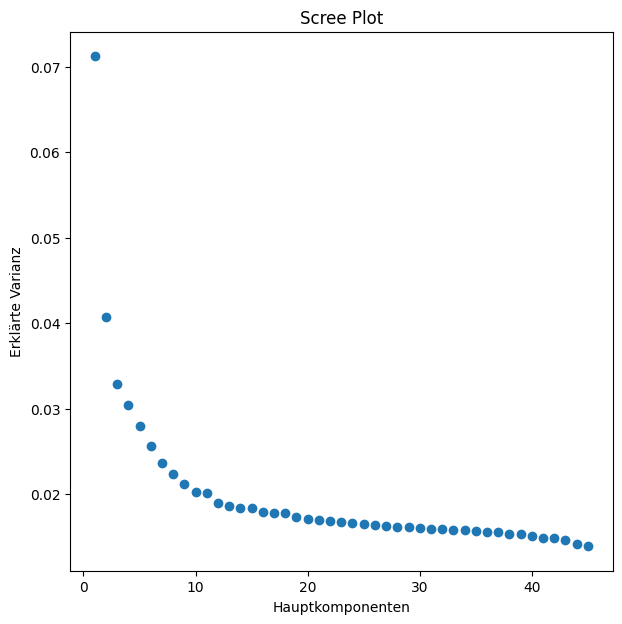

In [28]:
plt.figure(figsize=(7,7))
PC_values = np.arange(pca_new.n_components_) + 1
plt.scatter(PC_values, pca_new.explained_variance_ratio_)

plt.title('Scree Plot')
plt.xlabel('Hauptkomponenten')
plt.ylabel('Erklärte Varianz')
plt.show()

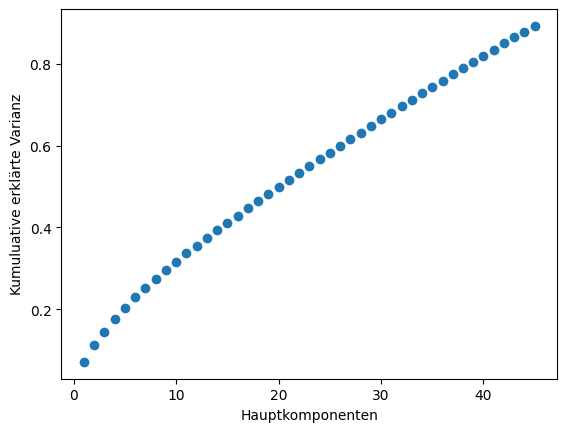

In [29]:
plt.xlabel('Hauptkomponenten')
plt.ylabel('Kumuluative erklärte Varianz')
plt.scatter(PC_values, np.cumsum(pca_new.explained_variance_ratio_))
plt.show()

# Cluster Analyse

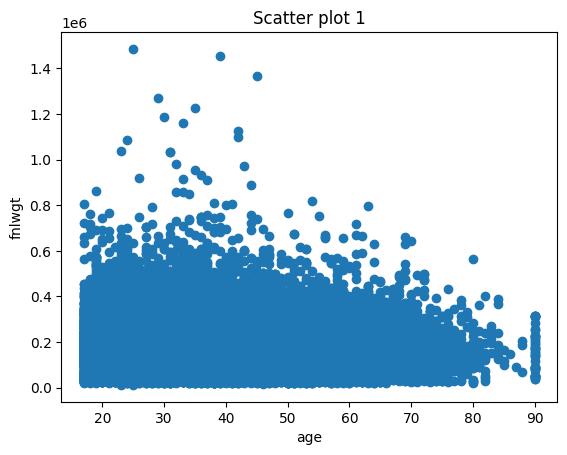

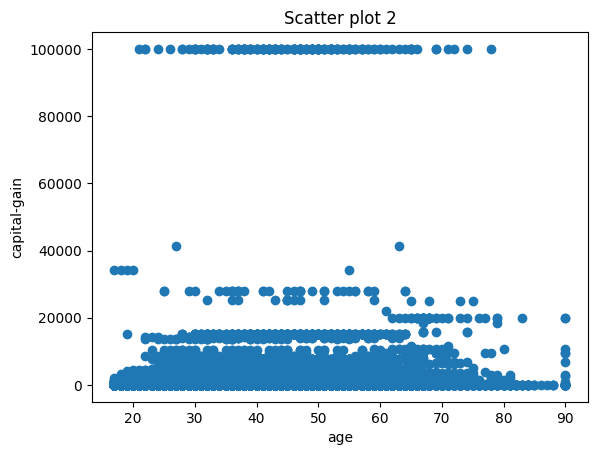

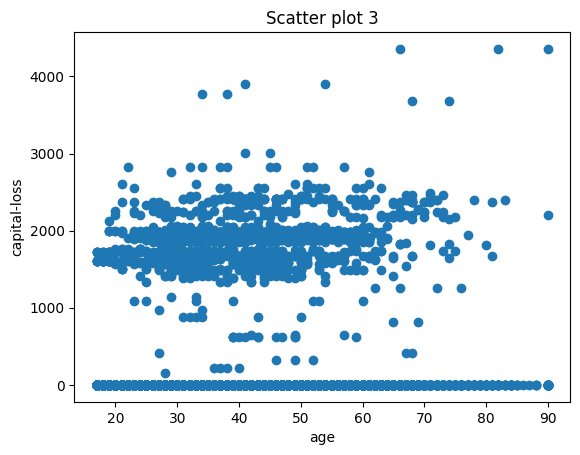

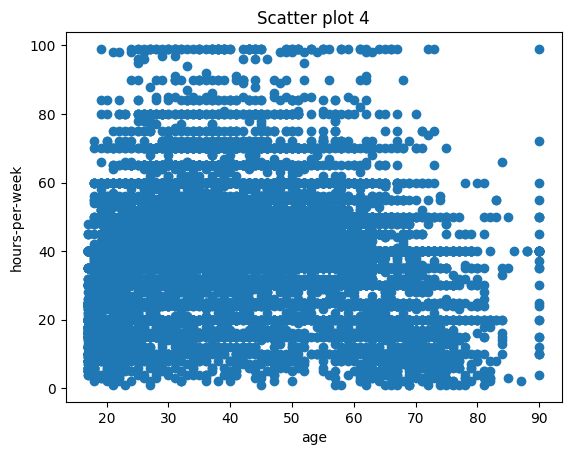

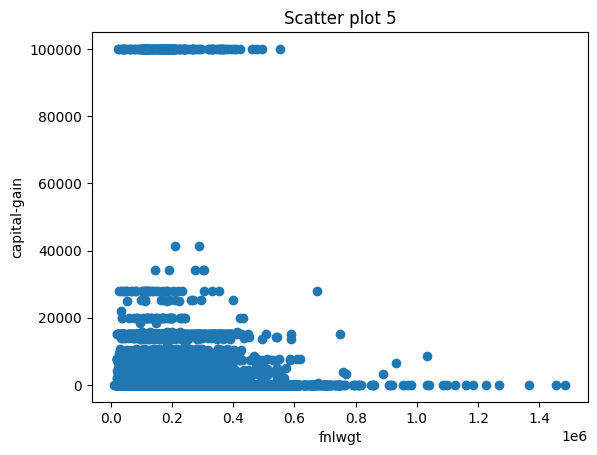

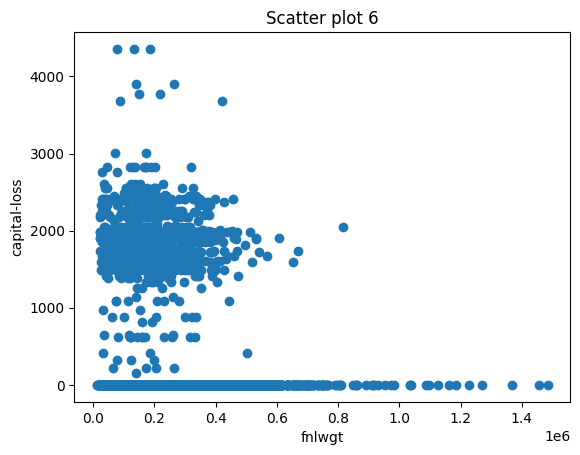

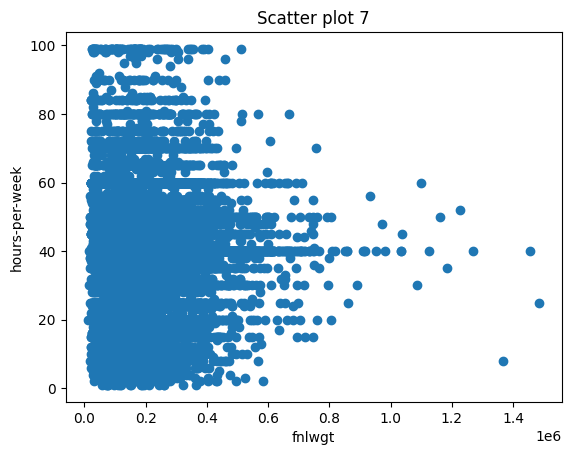

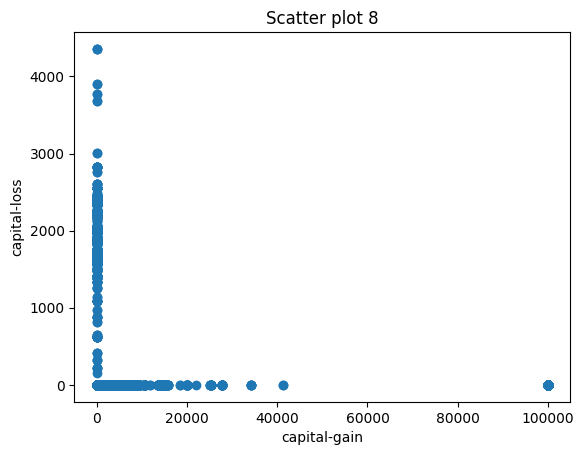

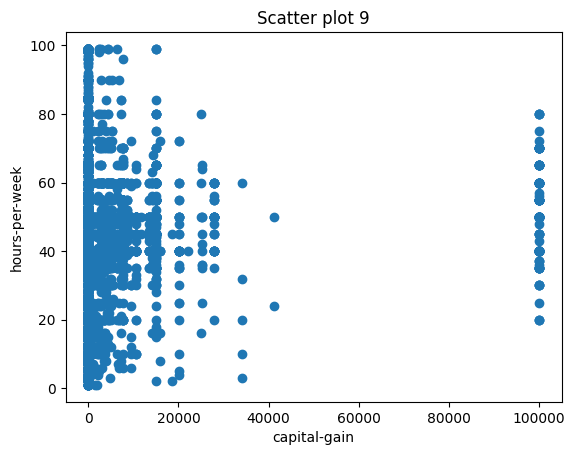

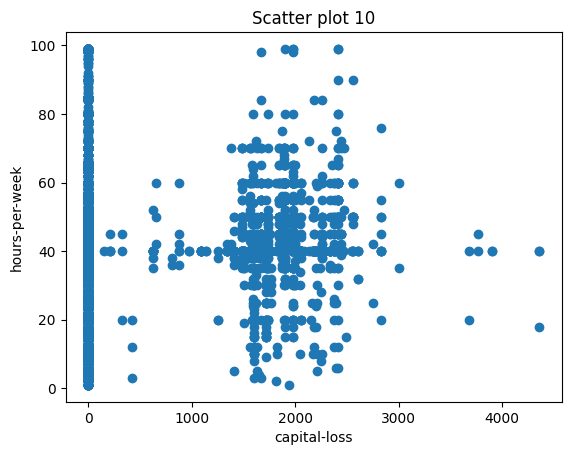

In [116]:


# #select the pair you want to plot

# """There are 5 categorical variables:

# workclass contains 8 labels
# education contains 16 labels
# marital-status contains 7 labels
# occupation contains 14 labels
# relationship contains 6 labels
# race contains 5 labels
# sex contains 2 labels
# native-country contains 41 labels

# There are 5 numeric variables:

# ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']
# """


# data_list = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']


# count = 1

# fig, ax = plt.subplots()
# for i in range(0,len(data_list)):
#     data1 = data_list[i]

#     for j in range(i+1, len(data_list)):

#         data2 = data_list[j]

#         X = train_df[[data1, data2]]

#         plt.figure(count)
#         scatter_plot = plt.scatter(train_df[data1], train_df[data2])   
#         plt.xlabel(data1)
#         plt.ylabel(data2)
#         plt.title('Scatter plot %i' %count)
#         count+=1


# plt.show()


c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

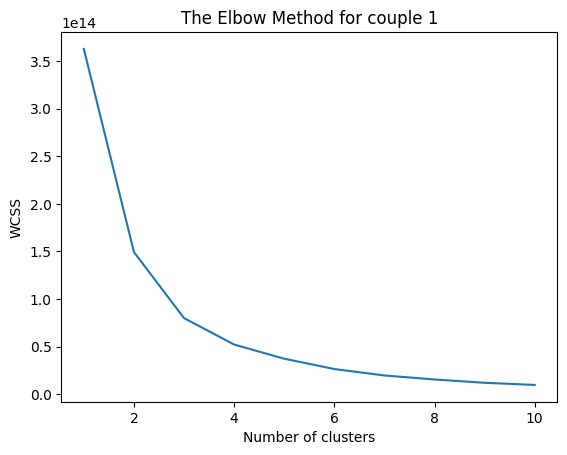

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

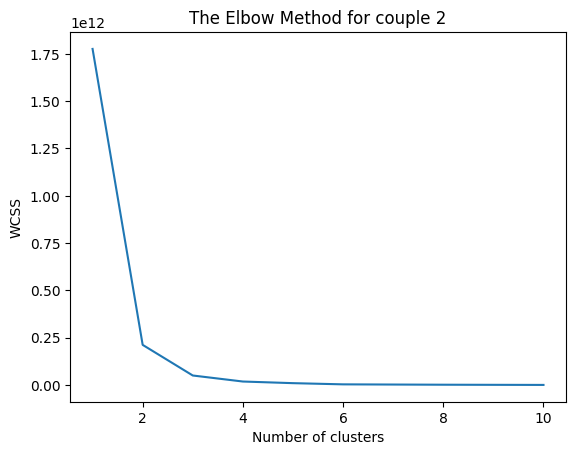

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

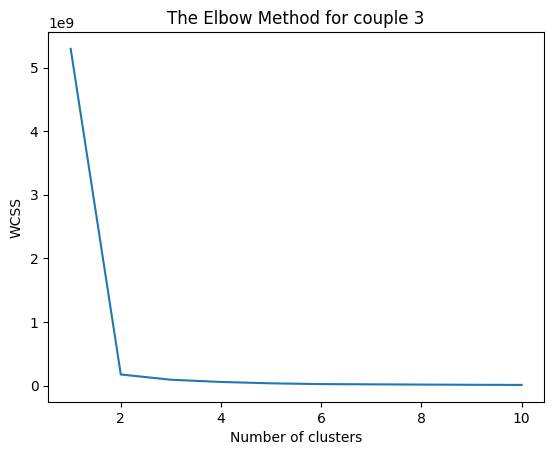

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

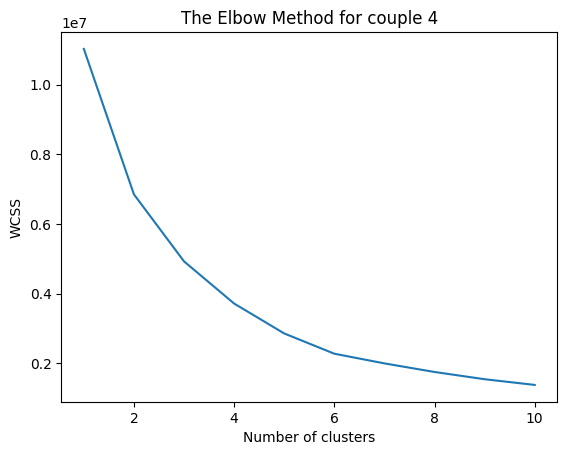

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

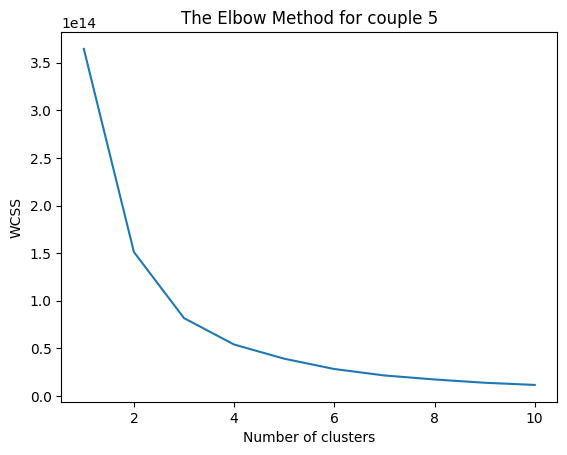

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

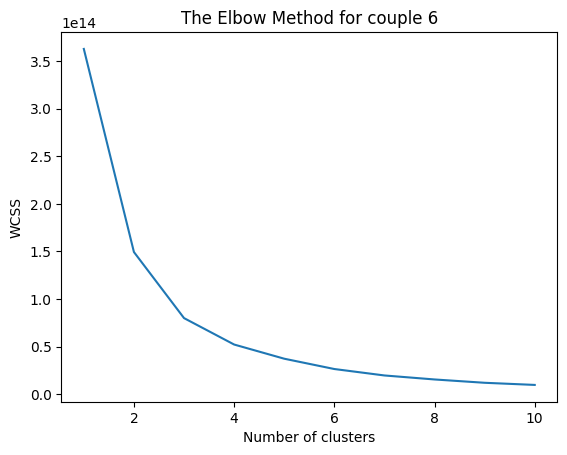

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

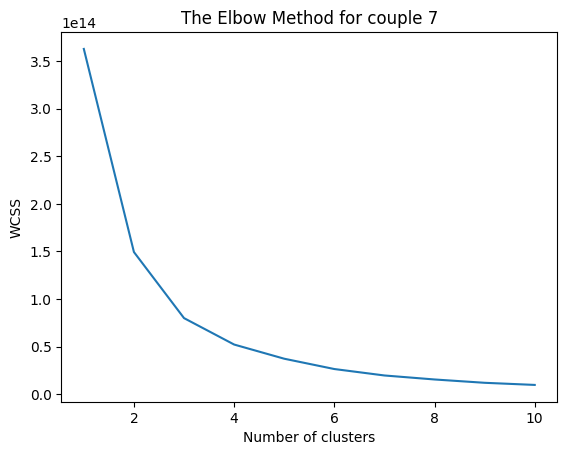

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

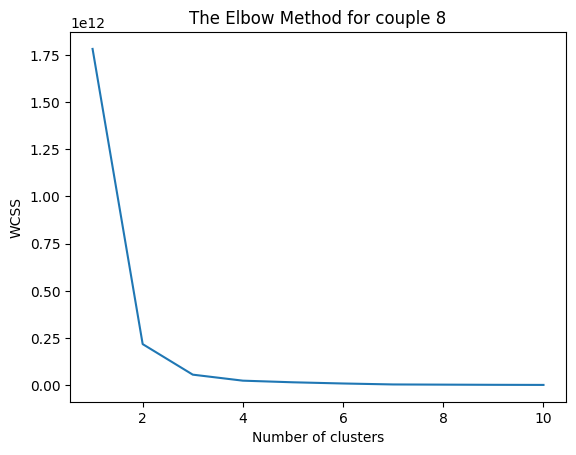

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

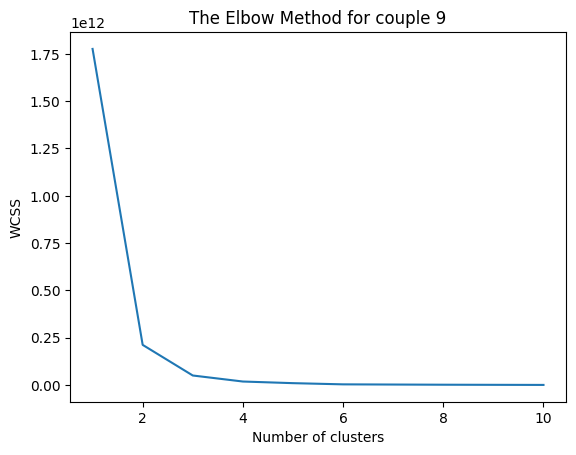

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

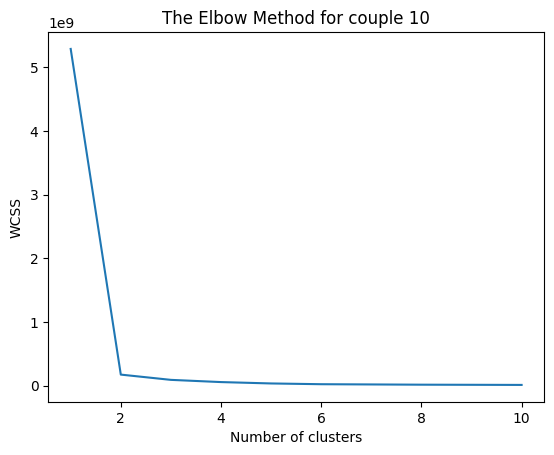

In [30]:
def kmeans_kvalues_plot(X,count):
  wcss = [] # the sum of the squared distance between each point and the centroid in a cluster
  for i in range(1, 11):
      kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state = 42)
      kmeans.fit(X)
      wcss.append(kmeans.inertia_)

      
  plt.plot(range(1, 11), wcss)
  plt.title(f'The Elbow Method for couple {count}' )
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.show()





count = 1
for i in range(0,len(data_list)):
    data1 = data_list[i]

    for j in range(i+1, len(data_list)):

        data2 = data_list[j]

        X = train_df[[data1, data2]]

        plt.figure(count)
        kmeans_kvalues_plot(X,count)
        
        count+=1
  

c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivar

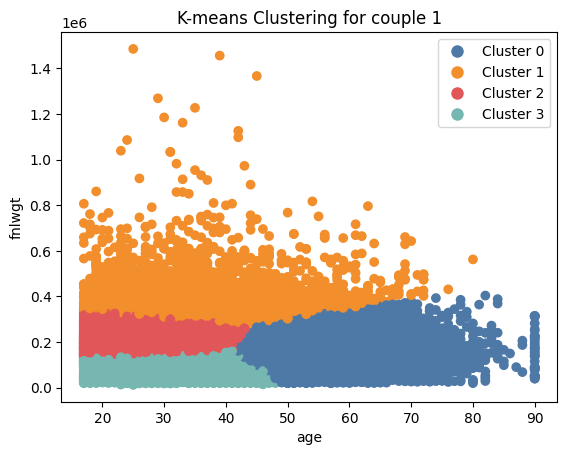

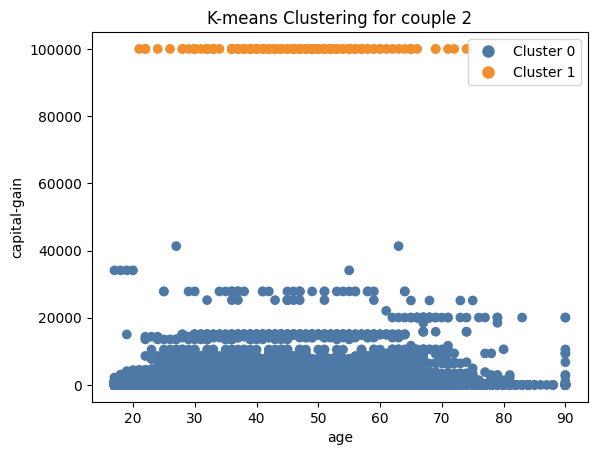

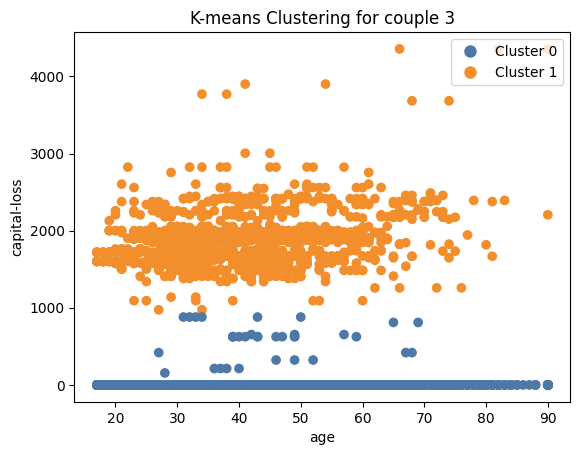

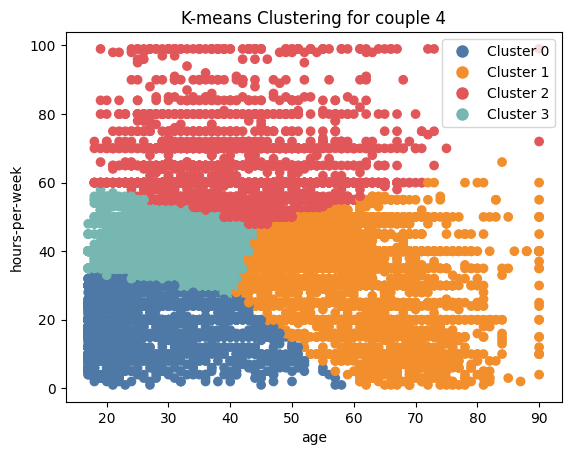

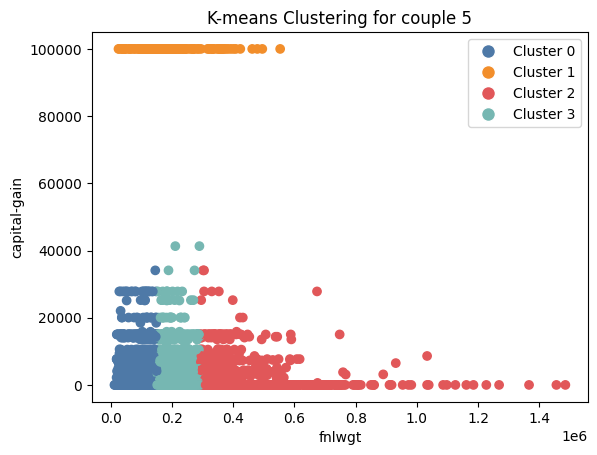

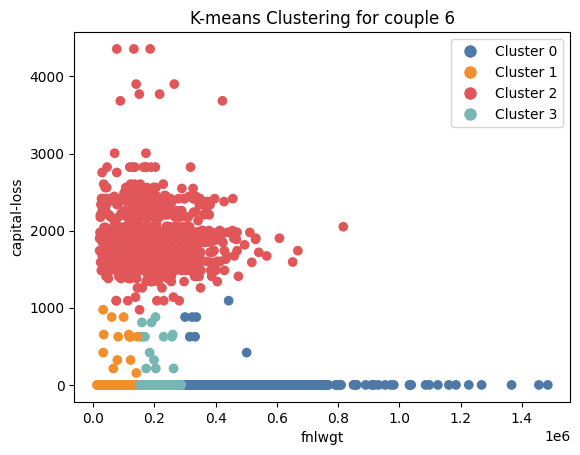

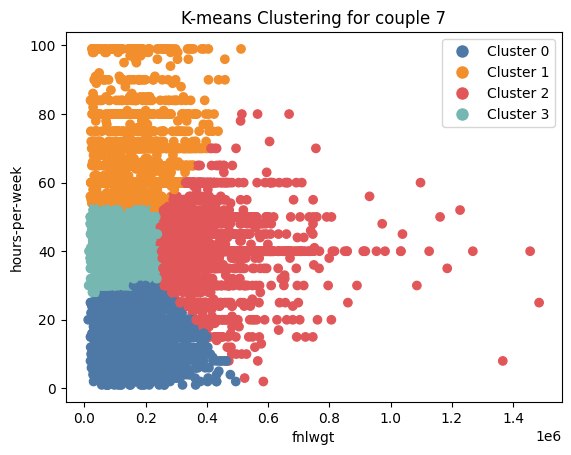

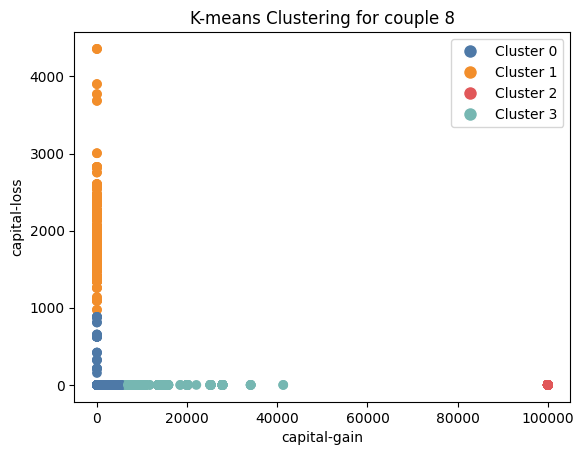

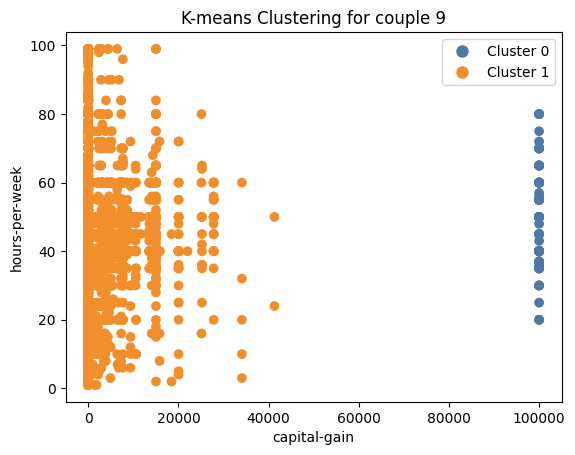

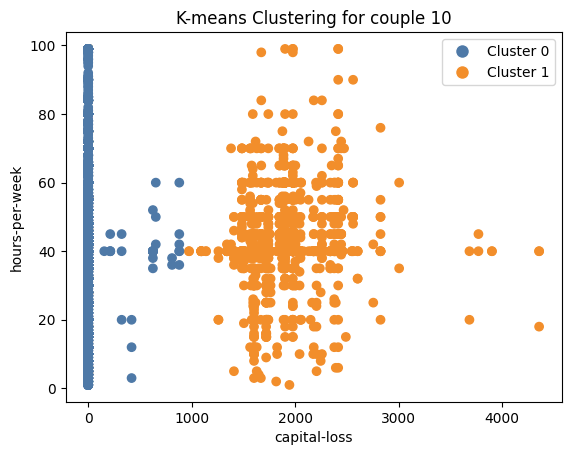

In [31]:
def kmeans_method(X, n_clusters):
  # Standardize the independent variables
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 42)
  y_kmeans = kmeans.fit_predict(X)
  
  return kmeans, y_kmeans

#you can twist this value
color_list = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

bounds_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


n_clusters_values = [4,2,2,4,4,4,4,4,2,2]

count = 1
for i in range(0,len(data_list)):
    data1 = data_list[i]

    for j in range(i+1, len(data_list)):

        data2 = data_list[j]

        X = train_df[[data1, data2]]
        color_list_seg = color_list[0:n_clusters_values[count-1]]
        bounds_list_seg = bounds_list[0:n_clusters_values[count-1]]

        cmap = ListedColormap(color_list_seg)
        norm = plt.Normalize(vmin=0, vmax=n_clusters_values[count-1])

        kmeans, y_kmeans = kmeans_method(X, n_clusters_values[count-1])
        X = X.values
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        plt.figure(count)
        scatter_plot = plt.scatter(train_df[data1], train_df[data2], c=labels,cmap=cmap, norm=norm)   #labels
        plt.xlabel(data1)
        plt.ylabel(data2)
        plt.title('K-means Clustering for couple %i' %count)

        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i), markerfacecolor=c, markersize=10) for i, c in enumerate(cmap.colors)]
        plt.legend(handles=legend_elements, loc='upper right')        
        
        count+=1

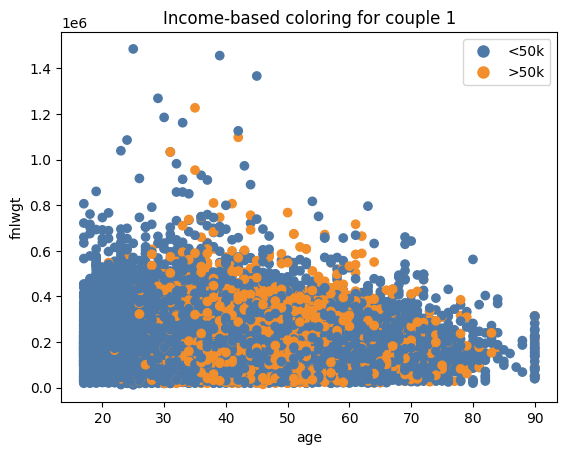

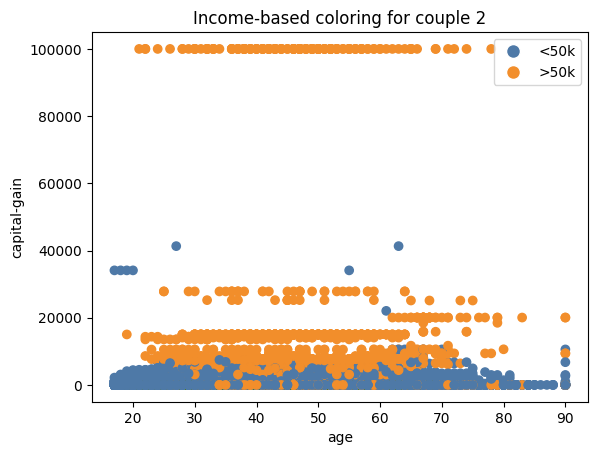

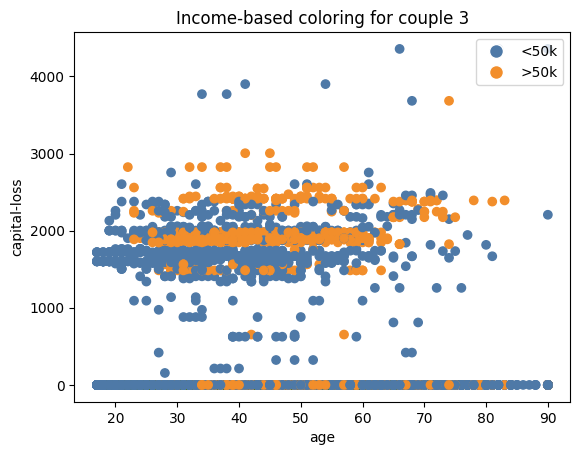

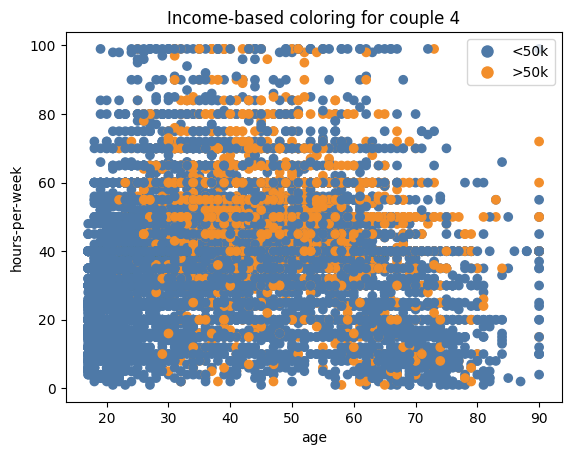

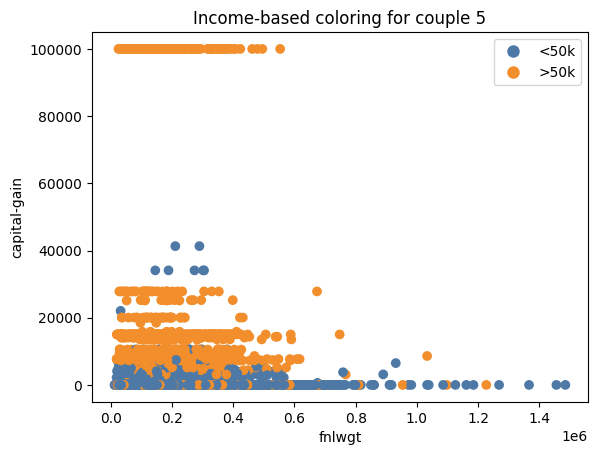

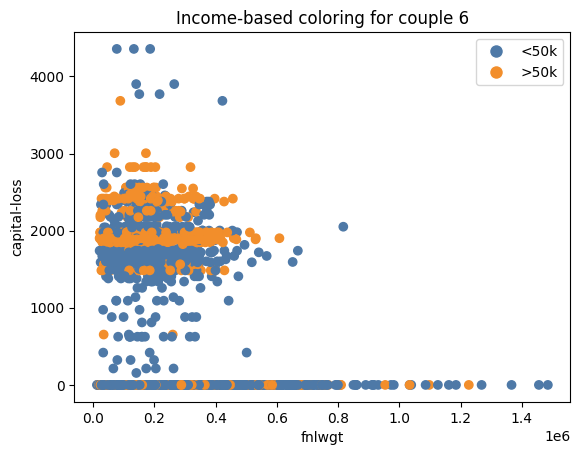

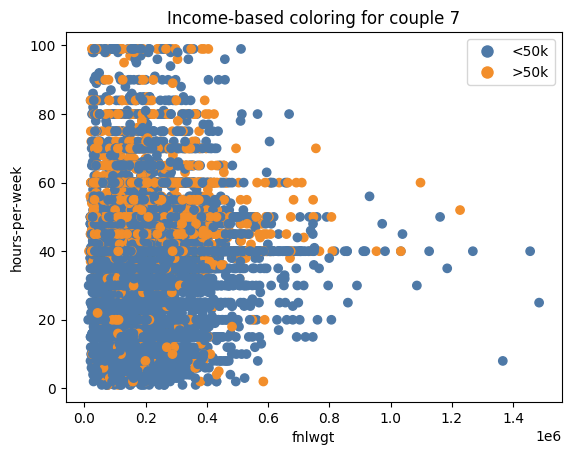

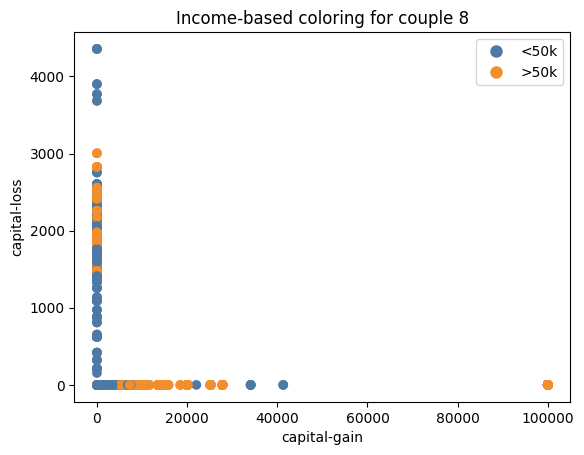

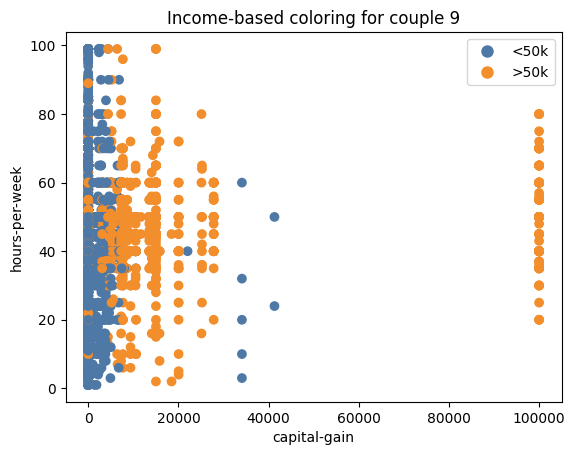

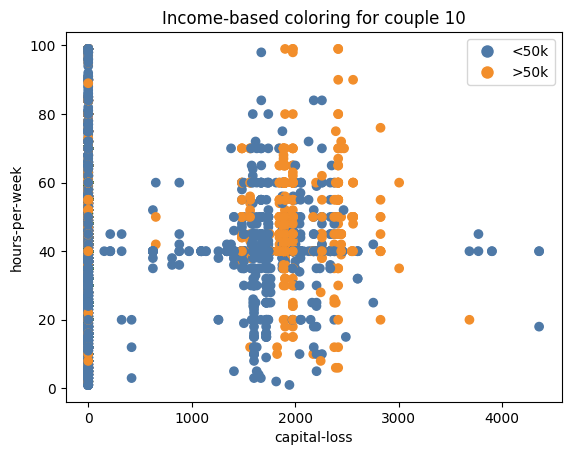

In [32]:

# count = 1
# for i in range(0,len(data_list)):
#     data1 = data_list[i]

#     for j in range(i+1, len(data_list)):

#         data2 = data_list[j]

#         X = train_df[[data1, data2]]

#         plt.figure(count)
        
        
#         scatter_plot = plt.scatter(train_df[data1], train_df[data2], c=train_df['income'],cmap=cmap, norm=norm)
#         plt.xlabel(data1)
#         plt.ylabel(data2)
#         cmap = ListedColormap(['#4e79a7', '#f28e2b'])
#         bounds = [0, 1, 2]
#         norm = plt.Normalize(vmin=0, vmax=2)
#         income_legends = ['<50k',">50k"]
#         legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=income_legends[i], markerfacecolor=c, markersize=10) for i, c in enumerate(cmap.colors)]
#         plt.legend(handles=legend_elements, loc='upper right')
#         plt.title('Income-based coloring for couple %i' %count) 
#         count+=1


# Final Data 

In [33]:
X_train = train_df.drop(["income"],axis=1)
Y_train = train_df['income']

X_test = test_df.drop(["income"],axis=1)
Y_test = test_df['income']

scaler_logit = MinMaxScaler()

# #Nur auf trainingsdaten fitten
x_train_scale = scaler_logit.fit(X_train)

x_train_scale = pd.DataFrame(scaler_logit.transform(X_train), columns=X_train.columns)
x_test_scale = pd.DataFrame(scaler_logit.transform(X_test), columns=X_test.columns)



# Logit-Modell

In [34]:
from statsmodels.discrete.discrete_model import Logit 

model = Logit(Y_train,X_train).fit_regularized()


c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3192107532856287
            Iterations: 460
            Function evaluations: 487
            Gradient evaluations: 460


In [35]:
from statsmodels.base.model import LikelihoodModelResults

model.mle_retvals

{'fopt': 0.3192107532856287,
 'converged': True,
 'iterations': 460,
 'gopt': nan,
 'hopt': nan,
 'trimmed': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]),
 'warnflag': '0 Optimization terminated successfully'}

In [36]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                 income   No. Observations:                32561
Model:                          Logit   Df Residuals:                    32498
Method:                           MLE   Df Model:                           62
Date:                Tue, 06 Jun 2023   Pseudo R-squ.:                  0.4217
Time:                        21:08:26   Log-Likelihood:                -10394.
converged:                       True   LL-Null:                       -17974.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.0230      0.002     14.319      0.000       0.020       0.026
workclass_1          1.5056   4.01e+05   3.75e-06      1.000   -7.86e+05    7.86e+05
workclass_2          1.2777 

In [37]:
yHat = model.predict(X_test)

In [38]:
prediction = list(map(round, yHat))
  
# comparing original and predicted values of y
print('Actual values', list(Y_test.values))
print('Predictions :', prediction)

Actual values [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

In [39]:
# confusion matrix
cm = confusion_matrix(Y_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print(f'Test accuracy = {accuracy_score(Y_test, prediction).round(4)*100} %')

Confusion Matrix : 
 [[11590   845]
 [ 1599  2247]]
Test accuracy = 84.99 %


In [40]:
model_scaled = Logit(Y_train,x_train_scale).fit_regularized()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3192106009125656
            Iterations: 507
            Function evaluations: 507
            Gradient evaluations: 507


In [41]:
model_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 income   No. Observations:                32561
Model:                          Logit   Df Residuals:                    32498
Method:                           MLE   Df Model:                           62
Date:                Tue, 06 Jun 2023   Pseudo R-squ.:                  0.4217
Time:                        21:08:30   Log-Likelihood:                -10394.
converged:                       True   LL-Null:                       -17974.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  1.6806      0.117     14.319      0.000       1.451       1.911
workclass_1          1.4651    6.6e+05   2.22e-06      1.000   -1.29e+06    1.29e+06
workclass_2          1.2372   6.81e+05   1.82e-06      1.000   -1.33e+06    1.33e+06
workclass_3          1.6734   5.85e+05   2.86e-06      1.000   -1.15e+06    1.15e+06
workclass_4          2.2577    6.3e+05   3.58e-06      1.000   -1.23e+06    1.23e+06
workclass_5          1.6148   6.42e+05   2.51e-06      1.000   -1.26e+06    1.26e+06
workclass_6          1.8825   6.81e+05   2.76e-06      1.000   -1.34e+06    1.34e+06
workclass_7         -8.9244   7.17e+05  -1.24e-05      1.000   -1.41e+06    1.41e+06
workclass_8         -3.5825   6.57e+05  -5.46e-06      1.000   -1.29e+06    1.29e+06
fnlwgt               0.8920      0.249      3.579      0.000       0.403       1.380
education_1          3.3157   5.38e+05   6.16e-06      1.000   -1.05e+06    1.05e+06
education_2          2.1102   5.38e+05   3.92e-06      1.000   -1.05e+06    1.05e+06
education_3          1.3484   5.59e+05   2.41e-06      1.000    -1.1e+06     1.1e+06
education_4          3.7056   5.81e+05   6.38e-06      1.000   -1.14e+06    1.14e+06
education_5          0.9935    5.7e+05   1.74e-06      1.000   -1.12e+06    1.12e+06
education_6          2.4808   5.61e+05   4.42e-06      1.000    -1.1e+06     1.1e+06
education_7          2.6784   5.75e+05   4.66e-06      1.000   -1.13e+06    1.13e+06
education_8          2.6795   5.51e+05   4.86e-06      1.000   -1.08e+06    1.08e+06
education_9          0.7369   5.55e+05   1.33e-06      1.000   -1.09e+06    1.09e+06
education_10         4.4587   5.68e+05   7.85e-06      1.000   -1.11e+06    1.11e+06
education_11         4.2733   5.51e+05   7.75e-06      1.000   -1.08e+06    1.08e+06
education_12         0.7892   5.59e+05   1.41e-06      1.000    -1.1e+06     1.1e+06
education_13         1.2807   5.73e+05   2.23e-06      1.000   -1.12e+06    1.12e+06
education_14         0.5082   5.26e+05   9.65e-07      1.000   -1.03e+06    1.03e+06
education_15       -20.5627    5.7e+05  -3.61e-05      1.000   -1.12e+06    1.12e+06
education_16         1.7169    5.4e+05   3.18e-06      1.000   -1.06e+06    1.06e+06
marital-status_1    -2.4104   1.15e+06  -2.09e-06      1.000   -2.26e+06    2.26e+06
marital-status_2     0.2320   1.15e+06   2.02e-07      1.000   -2.25e+06    2.25e+06
marital-status_3    -1.9163   1.15e+06  -1.66e-06      1.000   -2.26e+06    2.26e+06
marital-status_4    -2.0214   1.15e+06  -1.76e-06      1.000   -2.25e+06    2.25e+06
marital-status_5    -2.0519   1.15e+06  -1.78e-06      1.000   -2.25e+06    2.25e+06
marital-status_6     0.6773   1.16e+06   5.84e-07      1.000   -2.27e+06    2.27e+06
marital-status_7    -1.8303   1.16e+06  -1.58e-06      1.000   -2.27e+06    2.27e+06
occupation_1         0.3750   1.77e+06   2.11e-07      1.000   -3.48e+06    3.48e+06
occupation_2         1.1265   1.79e+06    6.3e-07      1.000    -3.5e+06     3.5e+06
occupation_

In [106]:
type(X_train['relationship_1'][0])

numpy.int64

In [95]:
X_train['relationship_5'].describe()

count    32561.000000
mean         0.105832
std          0.307627
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: relationship_5, dtype: float64

In [42]:
y_hat_scaled = model_scaled.predict(x_test_scale)

In [43]:
prediction2 = list(map(round, y_hat_scaled))
  
# comparing original and predicted values of y
print('Actual values', list(Y_test.values))
print('Predictions :', prediction2)

Actual values [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

In [44]:
cm2 = confusion_matrix(Y_test, prediction2) 
print ("Confusion Matrix : \n", cm2) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(Y_test, prediction2))

Confusion Matrix : 
 [[11590   845]
 [ 1599  2247]]
Test accuracy =  0.8498863706160555


## Logarithmic transformation

In [45]:
X_train['age']  = np.log(X_train['age'])
X_train['fnlwgt']  = np.log(X_train['fnlwgt'])

In [84]:
model_transformed = Logit(Y_train,X_train).fit_regularized()


c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.317266602407923
            Iterations: 445
            Function evaluations: 463
            Gradient evaluations: 445


In [85]:
model_transformed.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Logit
===============================================================================
Model:                    Logit                Pseudo R-squared:     0.425     
Dependent Variable:       income               AIC:                  20787.0357
Date:                     2023-06-06 21:27     BIC:                  21315.6605
No. Observations:         32561                Log-Likelihood:       -10331.   
Df Model:                 62                   LL-Null:              -17974.   
Df Residuals:             32498                LLR p-value:          0.0000    
Converged:                1.0000               Scale:                1.0000    
No. Iterations:           445.0000                                             
-------------------------------------------------------------------------------
                  Coef.     Std.Err.     z    P>|z|      [0.025       0.975]   
-------------------------------------------------------------------------------
age                1.2360      0.0690 17.9015 0.0000        1.1007       1.3713
workclass_1        1.0553  59064.3344  0.0000 1.0000  -115762.9128  115765.0235
workclass_2        0.8074  81594.0840  0.0000 1.0000  -159920.6585  159922.2733
workclass_3        1.2673         nan     nan    nan           nan          nan
workclass_4        1.8302         nan     nan    nan           nan          nan
workclass_5        1.1895         nan     nan    nan           nan          nan
workclass_6        1.4482         nan     nan    nan           nan          nan
workclass_7       -8.4402  79481.3844 -0.0001 0.9999  -155789.0911  155772.2107
workclass_8       -2.0972         nan     nan    nan           nan          nan
fnlwgt             0.1182      0.0284  4.1673 0.0000        0.0626       0.1738
education_1        1.8828 838536.3876  0.0000 1.0000 -1643499.2367 1643503.0023
education_2        0.6687 872163.7713  0.0000 1.0000 -1709408.9117 1709410.2491
education_3       -0.0798 900774.0616 -0.0000 1.0000 -1765484.7987 1765484.6391
education_4        2.2465 873388.4865  0.0000 1.0000 -1711807.7315 1711812.2245
education_5       -0.4596 882904.9729 -0.0000 1.0000 -1730462.4083 1730461.4890
education_6        1.0493 879265.4765  0.0000 1.0000 -1723327.6175 1723329.7162
education_7        1.2465 869485.6777  0.0000 1.0000 -1704159.3668 1704161.8599
education_8        1.2487 892319.9729  0.0000 1.0000 -1748913.7608 1748916.2582
education_9       -0.7287 832838.7160 -0.0000 1.0000 -1632334.6171 1632333.1596
education_10       2.9887 834354.1352  0.0000 1.0000 -1635301.0666 1635307.0440
education_11       2.8197 867359.6559  0.0000 1.0000 -1699990.8675 1699996.5068
education_12      -0.6807 887515.4741 -0.0000 1.0000 -1739499.0456 1739497.6842
education_13      -0.1748 876830.7531 -0.0000 1.0000 -1718556.8714 1718556.5219
education_14      -0.9628 886639.1318 -0.0000 1.0000 -1737781.7283 1737779.8027
education_15     -14.8259 866462.9284 -0.0000 1.0000 -1698250.9594 1698221.3076
education_16       0.2828 878048.9587  0.0000 1.0000 -1720944.0530 1720944.6185
marital-status_1  -2.5110 952385.7245 -0.0000 1.0000 -1866644.2303 1866639.2084
marital-status_2   0.0887 967123.4853  0.0000 1.0000 -1895527.1111 1895527.2886
marital-status_3  -2.1245 962274.5606 -0.0000 1.0000 -1886025.6065 1886021.3576
marital-status_4  -2.2104 959782.8932 -0.0000 1.0000 -1881142.1140 1881137.6931
marital-status_5  -2.2394 956469.9802 -0.0000 1.0000 -1874648.9529 1874644.4741
marital-status_6   0.6575 959724.8704  0.0000 1.0000 -1881025.5237 1881026.8386
marital-status_7  -2.0431 963200.0473 -0.0000 1.0000 -1887839.4457 1887835.3595
occupation_1      -0.1482         nan     nan    nan           nan          nan
occupation_2       0.6006         nan     nan    nan           nan          nan
occupation_3      -0.7878         nan     nan    nan           nan          nan
occupation_4       0.0711         nan     nan    nan           n

In [86]:
yhat_transformed = model_transformed.predict(X_test)
prediction_transformed = list(map(round, yhat_transformed))
  
# comparing original and predicted values of y
print('Actual values', list(Y_test.values))
print('Predictions :', prediction_transformed)

Actual values [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1

In [87]:
cm3 = confusion_matrix(Y_test, prediction_transformed) 
print ("Confusion Matrix : \n", cm3) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(Y_test, prediction_transformed))

Confusion Matrix : 
 [[    0 12435]
 [    0  3846]]
Test accuracy =  0.23622627602727106


# Scikit

In [46]:

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_scale,Y_train)

y_train_hat =logisticRegr.predict(x_train_scale)
train_accuracy = accuracy_score(Y_train, y_train_hat)*100
print('"Accuracy for our Training dataset without PCA is: %.4f %%' % train_accuracy)


"Accuracy for our Training dataset without PCA is: 85.0035 %


c:\Users\felix\OneDrive\Felix Stuff\Uni\Master\Multivariate Analysemethoden\income-classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
y_test_hat = logisticRegr.predict(x_test_scale)
test_accuracy = accuracy_score(Y_test, y_test_hat)*100
print('"Accuracy for our Test dataset without PCA is: %.4f %%' % test_accuracy)

"Accuracy for our Test dataset without PCA is: 84.9395 %


### With PCA reduction


In [48]:
x_pca_train = pca_new.fit_transform(pca_train_df_scale)
x_pca_test = pca_new.fit_transform(pca_test_df_scale)

x_pca_train = pd.DataFrame(x_pca_train)

logit = LogisticRegression()
logit.fit(x_pca_train,Y_train)


LogisticRegression()

In [49]:
y_pca_test_hat = logit.predict(x_pca_test)
test_accuracy = accuracy_score(Y_test, y_pca_test_hat)*100
print('"Accuracy for our Test dataset with PCA is: %.4f %%' % test_accuracy)

"Accuracy for our Test dataset with PCA is: 76.9117 %


### Vielleicht hier nochmal Parameter Tuning machen mit einem for loop bei verschiedenen n

# Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier as rfc
forest = rfc()
forest.fit(x_train_scale,Y_train)


RandomForestClassifier()

In [51]:
y_rfc_hat = forest.predict(x_train_scale)

In [52]:
print(forest.score(x_train_scale,Y_train))
print(forest.score(x_test_scale,Y_test))

0.9999385768250361
0.8497021067501996


In [53]:
pd.DataFrame(forest.feature_importances_, index=x_train_scale.columns).sort_values(by=0, ascending=False)

0
fnlwgt            0.174540
age               0.158796
capital-gain      0.106772
hours-per-week    0.087195
marital-status_2  0.072284
...                    ...
education_15      0.000189
occupation_14     0.000134
workclass_7       0.000064
occupation_13     0.000018
workclass_8       0.000009

[63 rows x 1 columns]

### Tuning


In [54]:
forest_2 = rfc(n_estimators=1000)
forest_2.fit(x_train_scale,Y_train)

RandomForestClassifier(n_estimators=1000)

In [55]:
y_rfc_hat_2 = forest_2.predict(x_train_scale)

In [56]:
print(forest_2.score(x_train_scale,Y_train))
print(forest_2.score(x_test_scale,Y_test))

0.9999692884125181
0.8510533750998096


In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [ 30, 40]
}
forest_tuned = rfc()


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = forest_tuned, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [58]:
'''

Muss nochmal verbessert werden bitte nicht löschen!

'''
# # Fit the grid search to the data
# grid_search.fit(x_pca_train, Y_train)
# grid_search.best_params_
# {'bootstrap': True,
#  'max_depth': 80,
#  'max_features': 3,
#  'min_samples_leaf': 5,
#  'min_samples_split': 12,
#  'n_estimators': 100}
# best_grid = grid_search.best_estimator_
# # grid_accuracy = evaluate(best_grid, x_pca_test, Y_test)
# # improvement =  100 * (grid_accuracy - base_accuracy) / base_accuracy
# # print('Improvement of {:0.2f}%.'.format(improvement))

'\n\nMuss nochmal verbessert werden bitte nicht löschen!\n\n'

# Neuronal Networks

In [59]:

model = tf.keras.models.Sequential() # Initializing
model.add(tf.keras.layers.Dense(units=64, activation='relu')) # input and 1st hidden layer
model.add(tf.keras.layers.Dense(units=64, activation='relu')) # 2nd hidden layer
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid')) # output layer
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # compiling, there are couple of methods
history = model.fit(x_train_scale, Y_train, batch_size = 32, epochs = 200)



Epoch 1/200
1018/1018 [==============================] - 2s 2ms/step - loss: 0.3607 - accuracy: 0.8321
Epoch 2/200
1018/1018 [==============================] - 2s 1ms/step - loss: 0.3294 - accuracy: 0.8456
Epoch 3/200
1018/1018 [==============================] - 1s 1ms/step - loss: 0.3204 - accuracy: 0.8497
Epoch 4/200
1018/1018 [==============================] - 2s 1ms/step - loss: 0.3150 - accuracy: 0.8531
Epoch 5/200
1018/1018 [==============================] - 2s 1ms/step - loss: 0.3118 - accuracy: 0.8552
Epoch 6/200
1018/1018 [==============================] - 2s 1ms/step - loss: 0.3085 - accuracy: 0.8573
Epoch 7/200
1018/1018 [==============================] - 1s 1ms/step - loss: 0.3071 - accuracy: 0.8558
Epoch 8/200
1018/1018 [==============================] - 1s 1ms/step - loss: 0.3034 - accuracy: 0.8584
Epoch 9/200
1018/1018 [==============================] - 2s 1ms/step - loss: 0.3012 - accuracy: 0.8591
Epoch 10/200
1018/1018 [==============================] - 2s 1ms/step - l

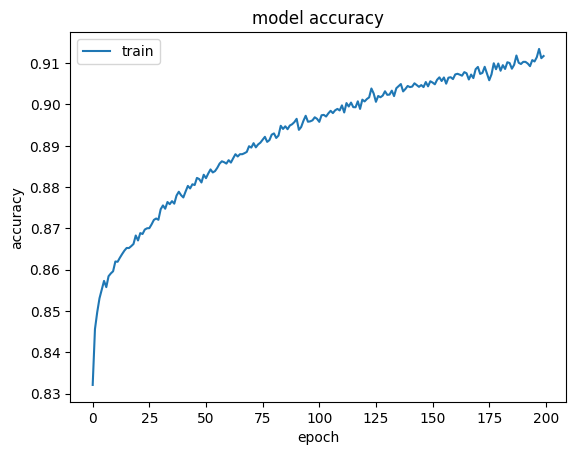

In [60]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

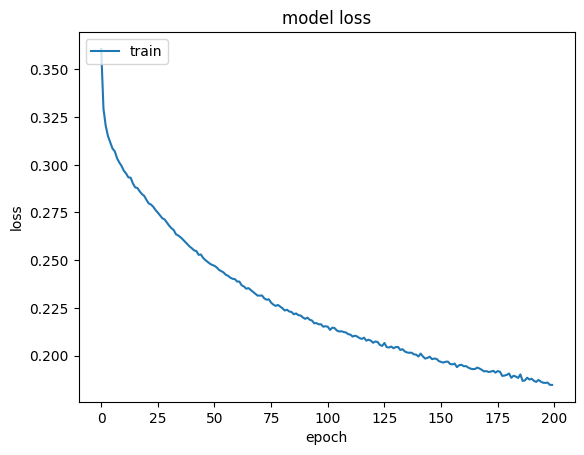

In [61]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()